In [ ]:
#!/usr/bin/env python
# coding: utf-8

# ==================================================================== #
# author: Yung-Hsin Chen                                               #
# copyright: Copyright 2020, Pneumonia Diagnosis                       #                                                            
# ==================================================================== #

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras import layers, models
import json
import pandas as pd
os.environ['KMP_DUPLICATE_LIB_OK']='True' # for MAC

Using TensorFlow backend.


### $\underline{Loading\;and\;Storing\;Data}$
##### - Classes: pneumonia, normal
##### - Train (228x228x5216), Validation (228x228x16), Test (228x228x624)

In [ ]:
imgX = imgY = 224
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.15,
    rotation_range=10,
    zoom_range=0.1,
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
path = '/content/drive/My Drive/Colab Notebooks/Pneumonia_ML/chest_x_ray'
train_generator = train_datagen.flow_from_directory(
    path + '/data/train',
    target_size = (imgX, imgY),
    batch_size = 100,#5216
    class_mode = "binary",
    shuffle = True
)
validation_generator = val_datagen.flow_from_directory(
    path +'/data/val',
    target_size = (imgX, imgY),
    batch_size = 16,
    class_mode = "binary",
    shuffle = False
)
test_generator = test_datagen.flow_from_directory(
    path +'/data/test',
    target_size = (imgX, imgY),
    batch_size = 5,#624
    class_mode = "binary",
    shuffle = False
)

Found 5226 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### $\underline{Neural\;Network\;Layers}$
##### - Pretrain: VGG16 (freeze)
##### - Dense (Sigmoid)
##### - Dropout (0.5)
##### - Dense (Sigmoid)

In [ ]:
model = tf.keras.Sequential()
# pretrain
pretrain = tf.keras.applications.vgg16.VGG16(weights = 'imagenet', include_top = False, input_tensor = tf.keras.layers.Input(shape=(imgX, imgY, 3)))
pretrain.trainable = False
model.add(pretrain)
# dropout - prevent overtraining
# lowering the capacity
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### $\underline{Model\;Summary}$

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


### $\underline{Training}$

In [ ]:
print("START COMPILING")
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.RMSprop(), metrics=[tf.keras.metrics.binary_crossentropy,'accuracy'])
print("START FITTING")
history = model.fit(train_generator, epochs = 10, validation_data = test_generator)
score = model.evaluate(test_generator, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[2])

START COMPILING
START FITTING
Epoch 1/10
53/53 [==============================] - 2954s 56s/step - loss: 0.6259 - binary_crossentropy: 0.6259 - accuracy: 0.8077 - val_loss: 0.3479 - val_binary_crossentropy: 0.3479 - val_accuracy: 0.8590
Epoch 2/10
53/53 [==============================] - 2943s 56s/step - loss: 0.2116 - binary_crossentropy: 0.2116 - accuracy: 0.9122 - val_loss: 0.4187 - val_binary_crossentropy: 0.4187 - val_accuracy: 0.8109
Epoch 3/10
53/53 [==============================] - 2983s 56s/step - loss: 0.1887 - binary_crossentropy: 0.1887 - accuracy: 0.9252 - val_loss: 0.5316 - val_binary_crossentropy: 0.5316 - val_accuracy: 0.7997
Epoch 4/10
53/53 [==============================] - 2946s 56s/step - loss: 0.1677 - binary_crossentropy: 0.1677 - accuracy: 0.9313 - val_loss: 0.2807 - val_binary_crossentropy: 0.2807 - val_accuracy: 0.8814
Epoch 5/10
53/53 [==============================] - 2946s 56s/step - loss: 0.1570 - binary_crossentropy: 0.1570 - accuracy: 0.9349 - val_loss:

In [ ]:
path_load = '/content/drive/My Drive/Colab Notebooks/Pneumonia_ML/chest_x_ray/model1'
with open(path_load + '/accuracy.txt', 'w') as fh_va:
  accuracy_result = [str(i) + '\n' for i in history.history['val_accuracy']]
  fh_va.writelines(accuracy_result)
with open(path_load + '/train_accuracy.txt', 'w') as fh_a:
  trainaccuracy_result = [str(i) + '\n' for i in history.history['accuracy']]
  fh_a.writelines(trainaccuracy_result)
with open(path_load + '/loss.txt', 'w') as fh_vl:
  loss_result = [str(i) + '\n' for i in history.history['val_loss']]
  fh_vl.writelines(loss_result)
with open(path_load + '/train_loss.txt', 'w') as fh_l:
  trainloss_result = [str(i) + '\n' for i in history.history['loss']]
  fh_l.writelines(trainloss_result)

In [ ]:
path_load = '/content/drive/My Drive/Colab Notebooks/Pneumonia_ML/chest_x_ray/model1'
fh_va = open(path_load + '/accuracy.txt', 'r')
accuracy = fh_va.readlines()
accuracy = [float(i) for i in accuracy]
fh_a = open(path_load + '/train_accuracy.txt', 'r')
train_accuracy = fh_a.readlines()
train_accuracy = [float(i) for i in train_accuracy]
fh_vl = open(path_load + '/loss.txt', 'r')
loss = fh_vl.readlines()
loss = [float(i) for i in loss]
fh_l = open(path_load + '/train_loss.txt', 'r')
train_loss = fh_l.readlines()
train_loss = [float(i) for i in train_loss]

(0.5, 1.0)

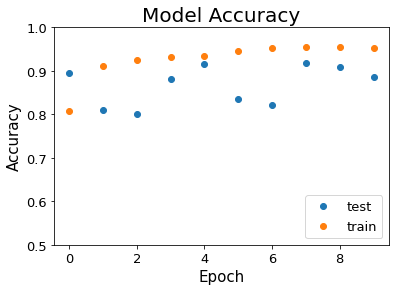

In [ ]:
plt.plot(accuracy, 'o', label = 'test')
plt.plot(train_accuracy, 'o', label = 'train')
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(loc='lower right', fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylim(0.5, 1)

(0.0, 1.0)

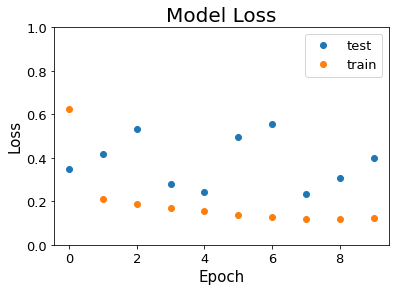

In [ ]:
plt.plot(loss, 'o', label = 'test')
plt.plot(train_loss, 'o', label = 'train')
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(loc='upper right', fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylim(0, 1)